Let's go.

In [2]:
import pandas as pd

In [3]:
def openData():
    df=pd.read_csv("../data.csv")
    return df
house=openData()
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   meter      912 non-null    int64  
 1   district   912 non-null    object 
 2   buildYear  912 non-null    int64  
 3   rooms      910 non-null    float64
 4   price      912 non-null    int64  
 5   elevator   912 non-null    bool   
 6   space      912 non-null    bool   
 7   parking    912 non-null    bool   
 8   floor      878 non-null    float64
dtypes: bool(3), float64(2), int64(3), object(1)
memory usage: 45.5+ KB


just working a bit with the dataset to understand what's going on. you can pass this.

In [4]:
print(house['district'].value_counts())
print(house.describe())

chitgar          44
poonak           41
jeyhoun          30
chitgar-lake     30
kooy-e-ferdos    28
                 ..
mahmoodiyeh       1
majid-abad        1
mina              1
tayeb             1
enqelab           1
Name: district, Length: 210, dtype: int64
            meter    buildYear       rooms         price       floor
count  912.000000   912.000000  910.000000  9.120000e+02  878.000000
mean    95.879386  1393.098684    1.942857  1.154656e+10    3.849658
std     51.661938     8.108967    0.736468  1.574038e+10    3.430056
min      1.000000  1370.000000    1.000000  5.500000e+06    1.000000
25%     61.000000  1386.000000    1.000000  3.500000e+09    2.000000
50%     83.000000  1395.000000    2.000000  7.300000e+09    3.000000
75%    115.000000  1401.000000    2.000000  1.380000e+10    4.000000
max    650.000000  1403.000000    4.000000  2.200000e+11   27.000000


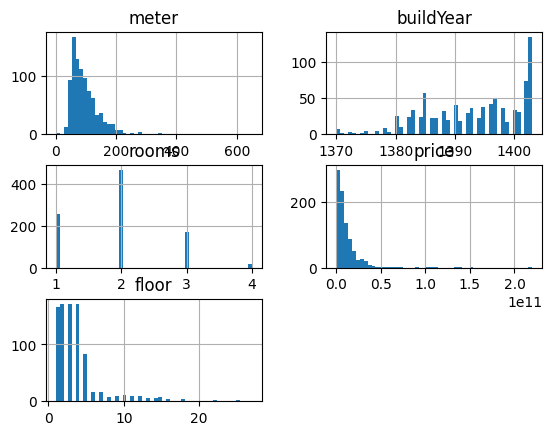

In [5]:
import matplotlib.pyplot as plt
house.hist(bins=50)
plt.show()

**making the test set**

In [6]:
from zlib import crc32
import numpy as np
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32
def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


adding an index to data as it's needed.

In [25]:
house_with_id = house.reset_index() # adds an `index` column
train_set, test_set = split_data_with_id_hash(house_with_id, 0.2, "index")

stratified sampling:

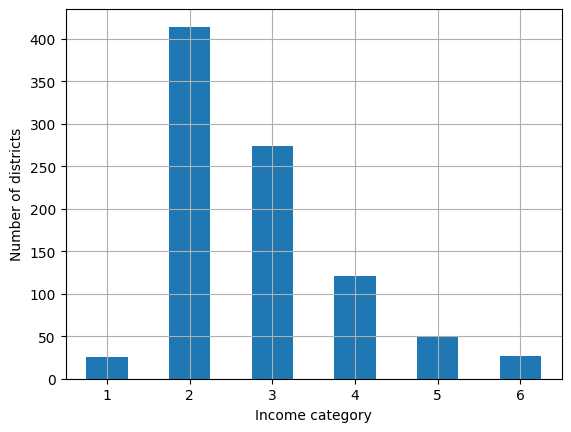

In [26]:
house["meter_cat"] = pd.cut(house["meter"],
bins=[0., 40, 80, 120, 160, 200., np.inf],
labels=[1, 2, 3, 4, 5, 6])
house["meter_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
stratSplits = []
for trainIndex, testIndex in splitter.split(house, house["meter_cat"]):
    stratTrainSetN = house.iloc[trainIndex]
    stratTestSetN = house.iloc[testIndex]
    stratSplits.append([stratTrainSetN, stratTestSetN])
    
stratTrainSet, stratTestSet = stratSplits[0]
print(stratTestSet["meter_cat"].value_counts() / len(stratTestSet))

2    0.453552
3    0.300546
4    0.131148
5    0.054645
6    0.032787
1    0.027322
Name: meter_cat, dtype: float64


In [29]:
for set_ in ( stratTrainSet ,stratTestSet):
    set_.drop("meter_cat", axis=1 , inplace=True)

/tmp/ipykernel_45914/117964952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("meter_cat", axis=1 , inplace=True)
/tmp/ipykernel_45914/117964952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("meter_cat", axis=1 , inplace=True)


_**START of the MODEL pre-process**_

In [34]:
house = stratTrainSet.copy()
corr_matrix = house.corr()
print(corr_matrix['price'].sort_values(ascending=False))

price        1.000000
meter        0.724424
rooms        0.535048
space        0.208003
elevator     0.190550
parking      0.112793
buildYear    0.109773
floor        0.000493
Name: price, dtype: float64


/tmp/ipykernel_45914/3448244544.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = house.corr()


_note 1_ : wow it seems that meter is really important!